In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('./drive/MyDrive/CMU/spring_2021/IDL/hw/hw5/nbs')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CMU/spring_2021/IDL/hw/hw5/nbs


In [ ]:
#default_exp autoencoder

# Autoencoder for Image Super-Resolution

## imports

In [ ]:
import os
os.chdir('..')

In [ ]:
!pip install torchinfo

In [ ]:
#export
# imports

import glob
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import numpy as np
import torch.nn as nn
from PIL import Image
from torchinfo import summary
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

## Dataset class

In [ ]:
#export
class PicturesDataset(Dataset):

    def __init__(self,
                 mode,
                 normalize=False,
                 data_augmentation=None,
                 interpolation=TF.InterpolationMode.NEAREST,
                 verbose=False):

        s = time.time()

        # Assertions to avoid wrong inputs
        assert mode in ['train', 'val', 'test']
        assert (mode != 'train' and data_augmentation == None) or mode == 'train'
        if data_augmentation != None:
            for item in data_augmentation:
                assert item in ['crop', 'rotate', 'flip']

        # Directory setup
        data_dirs = {'train': './data/train',
                     'val': './data/val',
                     'test': './data/test'}

        self.data_dir = data_dirs[mode]
        self.mode = mode
        self.data_augmentation = data_augmentation
        self.normalize = normalize
        self.verbose = verbose
        self.interpolation = interpolation

        if mode != 'test':
            self.file_names_lr = sorted(glob.glob(f'{self.data_dir}/lr/*.png'))
            self.file_names_hr = sorted(glob.glob(f'{self.data_dir}/hr/*.png'))

        else:
            self.file_names_lr = []
            for dir in os.listdir(self.data_dir):
                self.file_names_lr += glob.glob(f'{self.data_dir}/{dir}/*.png')
            self.file_names_lr = sorted(self.file_names_lr)

        if verbose: print(f'class PicturesDataset Init time: {time.time() - s:0.2f}')
   

    def __len__(self): 
        return len(self.file_names_lr)

    def __getitem__(self, idx):
            
        # Low resolution image (x)
        s = time.time()
        pic_lr = transforms.ToTensor()(Image.open(self.file_names_lr[idx]))
        if self.verbose: print(f'LR image reading time: {time.time() - s:0.2f}')

        # Flip dimensions to have height as longest dimension
        s = time.time()
        if pic_lr.shape[2] > pic_lr.shape[1]:
            pic_lr = pic_lr.transpose(1, 2)
        if self.verbose: print(f'LR Flipping time: {time.time() - s:0.2f}')

        # Normalization
        s = time.time()
        if self.normalize:
            pic_lr_mean = torch.mean(pic_lr)
            pic_lr_std = torch.std(pic_lr)
            pic_lr = (pic_lr - pic_lr_mean) / pic_lr_std
        if self.verbose: print(f'LR Normalization time: {time.time() - s:0.2f}')

        # 4x rescaling
        s = time.time()
        pic_lr_h, pic_lr_w = pic_lr.shape[1], pic_lr.shape[2]
        pic_lr = transforms.Resize(size=[4*pic_lr_h, 4*pic_lr_w],
                                   interpolation=self.interpolation)(pic_lr)
        if self.verbose: print(f'LR Rescaling time: {time.time() - s:0.2f}')        
        
        if self.mode != 'test':

            # High resolution image (target, just for training and validation)
            s = time.time()
            pic_hr = transforms.ToTensor()(Image.open(self.file_names_hr[idx]))
            if self.verbose: print(f'HR image reading time: {time.time() - s:0.2f}')

            # Flip dimensions to have height as longest dimension
            s = time.time()
            if pic_hr.shape[2] > pic_hr.shape[1]:
                pic_hr = pic_hr.transpose(1, 2)
            if self.verbose: print(f'HR Flipping time: {time.time() - s:0.2f}')

            # Normalization
            s = time.time()
            if self.normalize:
                pic_hr = (pic_hr - torch.mean(pic_hr)) / torch.std(pic_hr)
            if self.verbose: print(f'HR Normalization time: {time.time() - s:0.2f}')

            # Data augmentation for x and target
            if self.data_augmentation != None:
                pic_lr, pic_hr = self.data_augmentation_transform(pic_lr, pic_hr)

            return pic_lr, pic_hr
        
        else:
            pic_lr_size = pic_lr_h, pic_lr_w
            pic_lr_norm_params = pic_lr_mean, pic_lr_std

            return pic_lr, pic_lr_size, pic_lr_norm_params

    def data_augmentation_transform(self, pic_lr, pic_hr):       

        assert pic_lr.shape == pic_hr.shape

        pic_h, pic_w = pic_lr.shape[1], pic_lr.shape[2]

        # Random rotation
        s = time.time()
        if 'rotate' in self.data_augmentation:
            angle = transforms.RandomRotation.get_params(degrees=[-45,45])

            pic_lr = TF.rotate(pic_lr, angle=angle)
            pic_hr = TF.rotate(pic_hr, angle=angle)
        if self.verbose: print(f'DA Rotation time: {time.time() - s:0.2f}')

        # Random flip
        s = time.time()
        if 'flip' in self.data_augmentation:

            # Random horizontal flipping
            if np.random.random() > 0.5:
                pic_lr = TF.hflip(pic_lr)
                pic_hr = TF.hflip(pic_hr)

            # Random vertical flipping
            if np.random.random() > 0.5:
                pic_lr = TF.vflip(pic_lr)
                pic_hr = TF.vflip(pic_hr)
        if self.verbose: print(f'DA Random Flipping time: {time.time() - s:0.2f}')

        # Random crop
        s = time.time()
        if 'crop' in self.data_augmentation:
            crop_factor = np.random.uniform(low=0.5, high=0.75)
            crop_h = np.round(crop_factor * pic_h, decimals=0).astype(int)
            crop_w = np.round(crop_factor * pic_w, decimals=0).astype(int)

            i, j, h, w = transforms.RandomCrop.get_params(pic_lr, 
                                                          output_size=(crop_h, crop_w))
            
            pic_lr = TF.crop(img=pic_lr, top=i, left=j, height=h, width=w)
            pic_hr = TF.crop(img=pic_hr, top=i, left=j, height=h, width=w)
        if self.verbose: print(f'DA Cropping time: {time.time() - s:0.2f}')

        # Resize to original shape
        s = time.time()
        original_size = transforms.Resize(size=[pic_h, pic_w], 
                                          interpolation=self.interpolation)
        pic_lr = original_size(pic_lr)
        pic_hr = original_size(pic_hr)
        if self.verbose: print(f'DA Resizing time: {time.time() - s:0.2f}')

        return pic_lr, pic_hr

In [ ]:
normalize=True
interpolation = TF.InterpolationMode.BILINEAR
verbose=True

dataset_train = PicturesDataset(mode='train', 
                          normalize=normalize, 
                          data_augmentation=['crop', 'rotate', 'flip'], 
                          interpolation=interpolation,
                          verbose=verbose)

dataset_val = PicturesDataset(mode='val', 
                          normalize=normalize, 
                          interpolation=interpolation,
                          verbose=verbose)

dataset_test = PicturesDataset(mode='test', 
                          normalize=normalize, 
                          interpolation=interpolation,
                          verbose=verbose)


class PicturesDataset Init time: 0.06


In [ ]:
train_dims = [transforms.ToTensor()(Image.open(f)).shape for f in dataset_train.file_names_hr]
val_dims   = [transforms.ToTensor()(Image.open(f)).shape for f in dataset_val.file_names_hr]
test_dims  = [transforms.ToTensor()(Image.open(f)).shape for f in dataset_test.file_names_lr]

In [ ]:
train_dims_ = [(max(s[1], s[2]), min(s[1], s[2])) for s in train_dims]
train_h = [s[0] for s in train_dims_]
train_w = [s[1] for s in train_dims_]
print(max(train_h))
print(max(train_w))
print(min(train_h))
print(min(train_w))
print()

val_dims_ = [(max(s[1], s[2]), min(s[1], s[2])) for s in val_dims]
val_h = [s[0] for s in val_dims_]
val_w = [s[1] for s in val_dims_]
print(max(val_h))
print(max(val_w))
print(min(val_h))
print(min(val_w))
print()

test_dims_ = [(max(s[1], s[2]), min(s[1], s[2])) for s in test_dims]
test_h = [s[0] for s in test_dims_]
test_w = [s[1] for s in test_dims_]
print(max(test_h))
print(max(test_w))
print(min(test_h))
print(min(test_w))
print()

2040
2040
2040
648

2040
2040
2040
816

320
256
64
57



In [ ]:
#export
def plot_pictures(dataset, idx='random'):

    if idx == 'random': idx = np.random.randint(0, dataset.__len__() + 1)

    if dataset.mode != 'test':

        start = time.time()
        pic_lr, pic_hr = dataset.__getitem__(idx)
        if dataset.verbose: print(f'Total time: {time.time() - start:0.2f}\n')

        shape_lr = pic_lr.shape
        shape_hr = pic_hr.shape
        pic_lr = np.clip(pic_lr.permute(1,2,0).numpy(), 0, 1)
        pic_hr = np.clip(pic_hr.permute(1,2,0).numpy(), 0, 1)
        file_lr = dataset.file_names_lr[idx]
        file_hr = dataset.file_names_hr[idx]

        fig, axs = plt.subplots(1,2, figsize=(15,15))
        axs[0].imshow(pic_lr)
        axs[0].set_title(f'Low Resolution Image\nSet: {dataset.mode}\nNormalized: {dataset.normalize}\n(shape: {shape_lr})\n{file_lr}')
        axs[1].imshow(pic_hr)
        axs[1].set_title(f'High Resolution Image\nSet: {dataset.mode}\nNormalized: {dataset.normalize}\n(shape: {shape_hr})\n{file_hr}')
        plt.show()

    else: 

        start = time.time()
        pic_lr, pic_lr_size, pic_lr_norm_params = dataset.__getitem__(idx)
        if dataset.verbose: print(f'Total time: {time.time() - start:0.2f}\n')

        shape_lr = pic_lr.shape
        file_lr = dataset.file_names_lr[idx]

        pic_lr_unnormalized = pic_lr * pic_lr_norm_params[1] + pic_lr_norm_params[0]
        shape_lr_unnormalized = pic_lr_unnormalized.shape

        resize_pic = transforms.Resize(size=[pic_lr_size[0], pic_lr_size[1]],
                                       interpolation=TF.InterpolationMode.BICUBIC)
        pic_lr_resized = resize_pic(pic_lr)
        shape_lr_resized = pic_lr_resized.shape

        pic_lr_resized_unnormalized = resize_pic(pic_lr_unnormalized)
        shape_lr_resized_unnormalized = pic_lr_resized_unnormalized.shape

        pic_lr = np.clip(pic_lr.permute(1,2,0).numpy(), 0, 1)
        pic_lr_unnormalized = np.clip(pic_lr_unnormalized.permute(1,2,0).numpy(), 0, 1)
        pic_lr_resized = np.clip(pic_lr_resized.permute(1,2,0).numpy(), 0, 1)
        pic_lr_resized_unnormalized = np.clip(pic_lr_resized_unnormalized.permute(1,2,0).numpy(), 0, 1)

        fig, axs = plt.subplots(2,2, figsize=(15,23))

        axs[0,0].imshow(pic_lr)
        axs[0,0].set_title(f'Low Resolution Image\nSet: {dataset.mode}\nNormalized: {True}\n(shape: {shape_lr})\n{file_lr}')

        axs[0,1].imshow(pic_lr_unnormalized)
        axs[0,1].set_title(f'Low Resolution Image\nSet: {dataset.mode}\nNormalized: {False}\n(shape: {shape_lr_unnormalized})\n{file_lr}')

        axs[1,0].imshow(pic_lr_resized)
        axs[1,0].set_title(f'Low Resolution Image\nOriginal size\nSet: {dataset.mode}\nNormalized: {True}\n(shape: {shape_lr_resized})\n{file_lr}')

        axs[1,1].imshow(pic_lr_resized_unnormalized)
        axs[1,1].set_title(f'Low Resolution Image\nOriginal size\nSet: {dataset.mode}\nNormalized: {False}\n(shape: {shape_lr_resized_unnormalized})\n{file_lr}')


        plt.show()

class PicturesDataset Init time: 6.08
LR image reading time: 0.18
LR Flipping time: 0.00
LR Normalization time: 0.00
LR Rescaling time: 0.00
Total time: 0.19



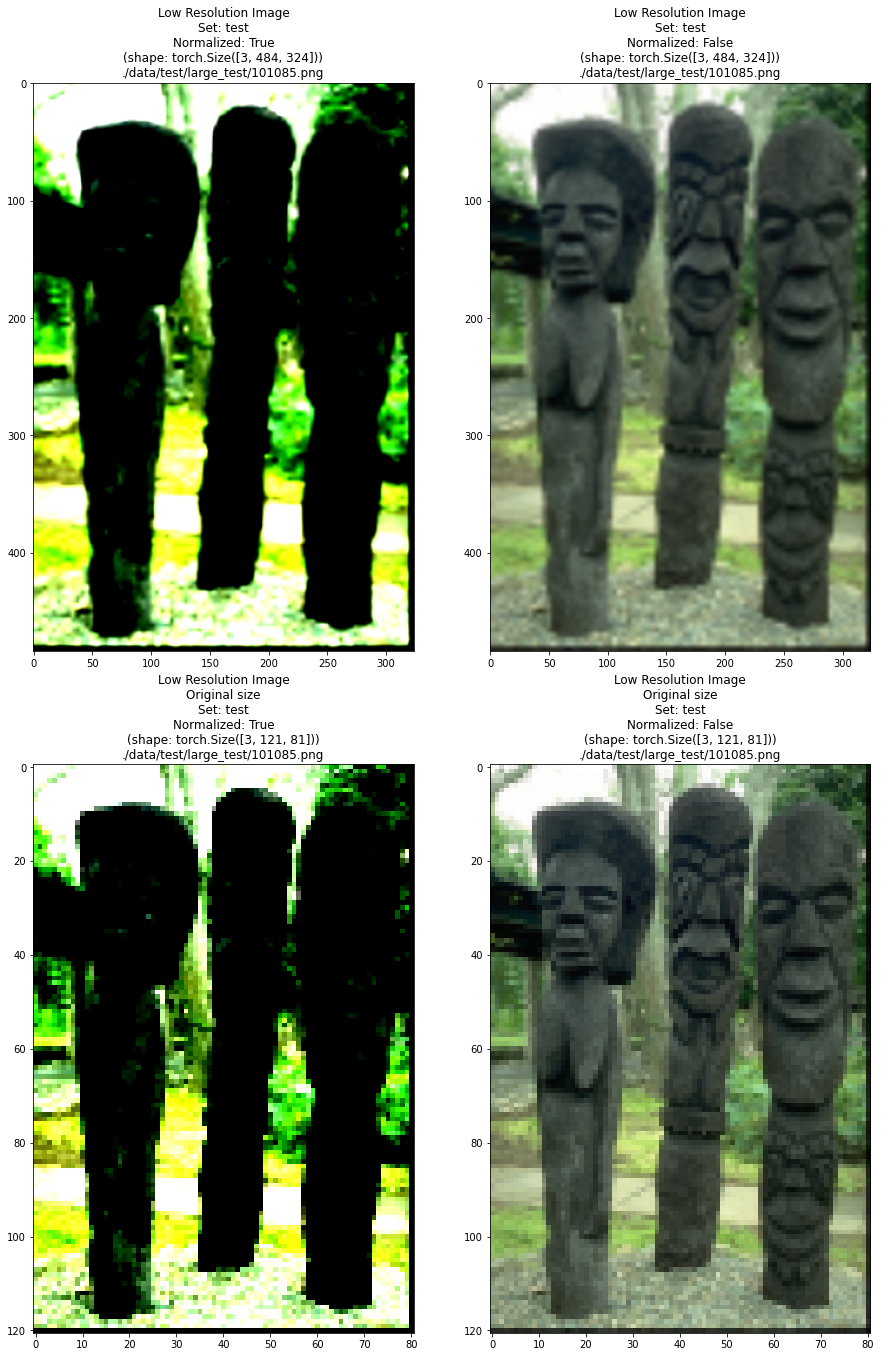

In [ ]:
mode = 'test'
normalize=True
data_augmentation = ['crop', 'rotate', 'flip'] if mode == 'train' else None
interpolation = TF.InterpolationMode.BILINEAR
verbose=True

dataset = PicturesDataset(mode=mode, 
                          normalize=normalize, 
                          data_augmentation=data_augmentation, 
                          interpolation=interpolation,
                          verbose=verbose)

plot_pictures(dataset=dataset, idx='random')

## Autoencoder Model

In [ ]:
#export
class autoencoder_(nn.Module):

    def __init__(self,
                 h_channels):

        super(autoencoder_, self).__init__()

        self.channels_enc = [3]
        self.channels_enc += h_channels.copy()
        self.channels_dec = [self.channels_enc[-1]]
        self.channels_dec += h_channels[::-1].copy()

        # Input layer: (B, C=3, H, W)

        # Encoder
        encoder_layers = []

        for i in range(len(h_channels)):
            layer = [nn.Conv2d(in_channels=self.channels_enc[i], 
                               out_channels=self.channels_enc[i+1], 
                               kernel_size=3,
                               padding=1),
                     nn.BatchNorm2d(num_features=self.channels_enc[i+1]),
                     nn.ReLU(),
                     nn.MaxPool2d(kernel_size=2,
                                  stride=2)]
            encoder_layers += layer

        self.encoder_layers = nn.ModuleList(encoder_layers)

        # Decoder
        decoder_layers = []

        for i in range(len(self.channels_dec) - 1):
            layer = [nn.ConvTranspose2d(in_channels=self.channels_dec[i], 
                                        out_channels=self.channels_dec[i+1], 
                                        kernel_size=2,
                                        stride=2),
                     nn.BatchNorm2d(num_features=self.channels_dec[i+1]),
                     nn.ReLU()]
            decoder_layers += layer

        decoder_layers += [nn.Conv2d(in_channels=self.channels_dec[i+1], 
                                    out_channels=self.channels_enc[0], 
                                    kernel_size=3,
                                    padding=1),
                           nn.BatchNorm2d(num_features=self.channels_enc[0]),
                           nn.ReLU()]
        
        self.decoder_layers = nn.ModuleList(decoder_layers)
        

    def forward(self, x):

        # Encoding (Convolutional Blocks - Downsampling)
        output_shapes = []

        for layer in self.encoder_layers:            
            if isinstance(layer, torch.nn.modules.pooling.MaxPool2d):
                output_shapes.append(x.shape)
            x = layer(x)

        output_shapes = output_shapes[::-1]

        # Decoding (Transpose Convolutional Blocks - Upsampling)
        for i, layer in enumerate(self.decoder_layers[:-3]):
            if i % 3 == 0: # if layer is ConvTranspose2D, then call it preserving output size from encoder
                x = layer(x, output_size=output_shapes[i//3])     
            else:
                x = layer(x)
        
        for layer in self.decoder_layers[-3:]:
            x = layer(x)
    
        return x


In [ ]:
dataset = PicturesDataset('train', normalize=True, data_augmentation=['crop', 'rotate', 'flip'])
idx = np.random.randint(0, dataset.__len__() + 1)

pic_lr, pic_hr = dataset.__getitem__(idx)
pic_lr = pic_lr.unsqueeze(0)

print(f'input  shape: {pic_lr.shape}')
model = autoencoder_(h_channels=[16, 32, 64, 128, 256])
out_pic = model(pic_lr)
print(f'output shape: {out_pic.shape}')

input  shape: torch.Size([1, 3, 813, 1224])
output shape: torch.Size([1, 3, 813, 1224])


In [ ]:
print(summary(model, input_size=(4, 3, 813, 1224)))

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-1                       [4, 16, 813, 1224]        448
|    └─BatchNorm2d: 2-2                  [4, 16, 813, 1224]        32
|    └─ReLU: 2-3                         [4, 16, 813, 1224]        --
|    └─MaxPool2d: 2-4                    [4, 16, 406, 612]         --
|    └─Conv2d: 2-5                       [4, 32, 406, 612]         4,640
|    └─BatchNorm2d: 2-6                  [4, 32, 406, 612]         64
|    └─ReLU: 2-7                         [4, 32, 406, 612]         --
|    └─MaxPool2d: 2-8                    [4, 32, 203, 306]         --
|    └─Conv2d: 2-9                       [4, 64, 203, 306]         18,496
|    └─BatchNorm2d: 2-10                 [4, 64, 203, 306]         128
|    └─ReLU: 2-11                        [4, 64, 203, 306]         --
|    └─MaxPool2d: 2-12                   [4, 64, 101, 153]         --
|    └